# Отчет по лабораторной работе "Наивный байесовский классификатор"

## Цели и задачи
**Цель:** изучение вероятностного классификатора на основе формулы Байеса.

**Основные задачи:**
- изучение принципов работы алгоритма наивного байесовского классификатора
- изучение метода максимального правдоподобия
- получение навыков анализа данных, используя наивный байесовский классификатор

## Задание 1.
Подберите по 10 и более предложений из текстов по разным областям. Реализуйте
простейший частотный байесовский классификатор для классификации входящего
предложения к одной из двух областей.

Для выполнения задания были выбраны два текста из двух различных областей. 

Первый текст представляет собой краткую справку о шведской поп-группе ABBA. Текст состоит из десяти предлжений и хранится в виде файла text1.txt. Источник: https://ru.wikipedia.org/wiki/ABBA

Второй текст представляет собой обзор статистики как науки, охватывающий её историю, определения и основные методы, содержит шестнадцать предложений в файле text2.txt. Источник: https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0

In [19]:
!pip3 install nltk
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize

# Загрузка необходимых ресурсов для токенизации
nltk.download('punkt')


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1028)>


In [20]:
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter

def read_and_tokenize(file_name, label):
    with open(file_name, 'r', encoding='utf-8') as file:
        text = file.read()
    sentences = sent_tokenize(text)  # Токенизация по предложениям
    return sentences, [label] * len(sentences)

def tokenize_words(sentences):
    words = []
    for sentence in sentences:
        words.extend(word_tokenize(sentence))  # Токенизация по словам
    return words

# Функция для удаления знаков препинания и тире
def remove_punctuation(words):
    return [re.sub(r'[\W_]+', '', word).strip() for word in words if re.sub(r'[\W_]+', '', word).strip() != '']  # Убрать все не буквенно-цифровые символы

# Пример использования функций:
labels = ['text1', 'text2']  # Разные метки для каждого текста
all_words = []
all_classes = []

for i, label in enumerate(labels):
    sentences, classes = read_and_tokenize(f'text{i+1}.txt', label)  # Читаем разные файлы
    for sentence in sentences:
        words = tokenize_words([sentence])  # Разделяем на слова
        words = remove_punctuation(words)  # Убираем знаки препинания
        all_words.extend(words)
        all_classes.extend([label] * len(words))  # Здесь метка будет повторяться для каждого слова в предложении

# Создаем DataFrame
data = {
    'Word': all_words,
    'Class': all_classes
}

df = pd.DataFrame(data)

# Подсчитываем частоту слов в text1
text1_words = df[df['Class'] == 'text1']['Word']
word_counter1 = Counter(text1_words)

# Добавляем столбец с частотой появления слова в text1
df['Frequency_in_text1'] = df['Word'].map(word_counter1)
df['Frequency_in_text1'] += 1

# Подсчитываем частоту слов в text2
text2_words = df[df['Class'] == 'text2']['Word']
word_counter2 = Counter(text2_words)

# Добавляем столбец с частотой появления слова в text2
df['Frequency_in_text2'] = df['Word'].map(word_counter2)
df['Frequency_in_text2'] += 1

# Вычисляем сумму для столбцов с частотой и добавляем ее в DataFrame
sum_row = pd.DataFrame({
    'Word': ['Total'],
    'Class': [''],
    'Frequency_in_text1': [df['Frequency_in_text1'].sum()],
    'Frequency_in_text2': [df['Frequency_in_text2'].sum()],
})

df = pd.concat([df, sum_row], ignore_index=True)


# Добавляем столбец с вероятностью
df['Probability_in_text1'] = df['Frequency_in_text1'] / df.iloc[483, 2]
df['Probability_in_text2'] = df['Frequency_in_text2'] / df.iloc[483, 3]

df

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/darina/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.13/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.13/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.13/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/Users/darina/Downloads/punkt'
    - '/Users/darina/Downloads'
**********************************************************************


Далее рассчитываются вероятности того, относится ли предложение  к тексту №1 или тексту №2, а итоговым прогнозом будет класс с максимальной вероятностью.

$P(C|M) = P(C) \cdot \prod_{i=1}^n P(w_i|C), \ \ w_i \in M$

Где:
- $C \in (text1, \ \ text2)$;
- $M$ — предложение;
- $w_i$ — i-е слово в предложении $M$;
- $P(text1) = \frac{10}{26} = 0.385$
- $P(text2) = \frac{16}{26} = 0.615$

In [10]:
def predict_class(sentence, df):
    # Удаляем знаки препинания и пробелы
    cleaned_sentence = re.sub(r'[^\w\s]', '', sentence)
    # Разделяем строку на слова
    words = cleaned_sentence.split()
    
    # Получаем уникальные слова
    unique_words = set(words)
    word_probabilities = {}

    for word in unique_words:
        # Если слово есть в DataFrame, получаем его вероятность
        prob_text1 = df[df['Word'].str.lower() == word.lower()]['Probability_in_text1']
        prob_text2 = df[df['Word'].str.lower() == word.lower()]['Probability_in_text2']
        
        word_probabilities[word] = {
            'Probability_in_text1': prob_text1.values[0] if not prob_text1.empty else 0,
            'Probability_in_text2': prob_text2.values[0] if not prob_text2.empty else 0,
        }

    # Создание DataFrame с вероятностями для слов из предложения
    probabilities_df = pd.DataFrame.from_dict(word_probabilities, orient='index').reset_index()
    probabilities_df.columns = ['Word', 'Probability_in_text1', 'Probability_in_text2']

    # Вычисление общей вероятности для каждого текста
    total_prob_text1 = 10 / 26
    total_prob_text2 = 16 / 26

    for word in words:
        if word in word_probabilities:
            prob_text1 = word_probabilities[word]['Probability_in_text1']
            prob_text2 = word_probabilities[word]['Probability_in_text2']
            
            total_prob_text1 *= prob_text1
            total_prob_text2 *= prob_text2

    # Определение класса для предложения
    if total_prob_text1 > total_prob_text2:
        result = f'Предложение относится к первому тексту с вероятностью {total_prob_text1}'
    else:
        result = f'Предложение относится ко второму тексту с вероятностью {total_prob_text2}'

    return probabilities_df, result

# Определение класса на примере предложения из второго текста (text2)
input_sentence = "Сначала под статистикой понимали описание экономического и политического состояния государства или его части."

probabilities_df, prediction = predict_class(input_sentence, df)
print(prediction)

probabilities_df


NameError: name 'df' is not defined

## Задание 2.

Подберите набор данных на ресурсе https://archive.ics.uci.edu/ для классификации

Для реализации модели классификации был выбран набор данных **Census Income Dataset**. Набор данных используется для задач анализа данных и машинного обучения. Этот набор был собран из данных переписи населения США и используется для исследования задач оценки дохода.

**Источник:** UCI Machine Learning Repository.

**Цель:** Предсказать, получает ли человек доход выше 50,000 долларов в год.



Набор данных состоит из 14 признаков, которые можно разделить на категориальные и числовые:

**Числовые признаки:**
- age: Возраст человека
- fnlwgt: Веса по населению, что представляет собой оценку количества людей, которые соответствуют конкретной записи.
- capital-gain: Прибыль от капитала, полученная человеком.
- capital-loss: Убыток от капитала, понесенный человеком.
- hours-per-week: Количество часов, отработанных в неделю.

**Категориальные признаки:**
- workclass: Категория занятости (например, частный сектор, государственный сектор, самозанятый и т. д.).
- education: Уровень образования (например, средняя школа, бакалавриат, аспирантура и т. д.).
- education-num: Числовой эквивалент уровня образования (например, средняя школа = 9, бакалавриат = 13).
- marital-status: Семейное положение (например, женат/замужем, холост/незамужем и т. д.).
- occupation: Род занятий (например, менеджер, техника, графический дизайнер и т. д.).
- relationship:(например, супруг, родитель, одиночка).
- race: Раса
- sex: Пол (мужской или женский).
- native-country: Страна происхождения (например, США, Мексика и т. д.).

**Целевой признак:**
- income: Категориальная переменная, указывающая, превышает ли доход 50,000 долларов в год (значения: <=50K или >50K).

In [21]:
## Подключение и работа с данными
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                'marital-status', 'occupation','relationship', 'race', 
                'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
                'native-country', 'income']
census_data = pd.read_csv(url, names=column_names)

#Обработка пропущенных значений
census_data = census_data.loc[census_data['native-country'] != ' ?']
census_data = census_data.loc[census_data['occupation'] != ' ?']
census_data = census_data.loc[census_data['workclass'] != ' ?']
census_data = census_data.loc[census_data['education'] != ' ?']
census_data = census_data.loc[census_data['race'] != ' ?']
census_data = census_data.loc[census_data['sex'] != ' ?']
census_data = census_data.loc[census_data['hours-per-week'] != ' ?']


data_less_equal_50k = census_data.loc[census_data['income'] == ' <=50K']
data_greater_than_50k = census_data.loc[census_data['income'] == ' >50K']

sample_less_equal_50k = data_less_equal_50k.head(300)
sample_greater_than_50k = data_greater_than_50k.head(300)
    
census_data= pd.concat([sample_less_equal_50k, sample_greater_than_50k])


census_data

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1028)>

## Задание 3.
Реализуйте модель классификации по байесовскому классификатору и оцените полученные результаты.

In [428]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions

In [429]:
pip install mlxtend


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Для работы с моделью прежде необходимо провести преобразование исходных данных. Преобразование категориальных данных позволяет использовать их в алгоритмах, требующих числовых форматов, а нормализация числовых переменных помогает моделям лучше обучаться, так как они не будут доминироваться признаками с более крупными масштабами.

In [430]:
from sklearn.preprocessing import LabelEncoder
 
# Convert categorical variables to numerical values
le = LabelEncoder()
categorical_features = ['workclass', 'marital-status',
                        'occupation', 'education', 'relationship', 'race', 'sex', 'native-country',
                         'income']
for feature in categorical_features:
    census_data[feature] = le.fit_transform(census_data[feature])

census_data[['age', 'fnlwgt', 'education-num', 'capital-gain',   'capital-loss', 'hours-per-week']] = census_data[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss','hours-per-week']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
 

# Отображение предобработанных данных
census_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.301370,5,0.055671,9,0.800000,4,0,1,4,1,0.021740,0.0,0.397959,21,0
1,0.452055,4,0.061397,9,0.800000,2,2,0,4,1,0.000000,0.0,0.122449,21,0
2,0.287671,2,0.192157,11,0.533333,0,4,1,4,1,0.000000,0.0,0.397959,21,0
3,0.493151,2,0.211005,1,0.400000,2,4,0,2,1,0.000000,0.0,0.397959,21,0
4,0.150685,2,0.313458,9,0.800000,2,7,5,2,0,0.000000,0.0,0.397959,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,0.452055,2,0.066945,11,0.533333,2,0,5,4,0,0.051781,0.0,0.397959,21,1
1286,0.410959,4,0.344791,9,0.800000,2,9,0,4,1,0.150242,0.0,0.500000,21,1
1302,0.561644,3,0.163645,15,0.600000,2,11,5,4,0,0.000000,0.0,0.397959,21,1
1305,0.273973,2,0.011357,9,0.800000,2,5,0,4,1,0.000000,0.0,0.428571,21,1


In [431]:
X = census_data.drop('income', axis=1)
y = census_data['income']
 
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


classes, cls_counts = np.unique(y_train, return_counts=True)
print(classes)
print(cls_counts)


[0 1]
[230 220]


In [432]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        classes, cls_counts = np.unique(y, return_counts=True)
        n_classes = len(classes)
        self.priors = cls_counts / len(y)

        # calculate the mean and standard deviations of features by classes
        self.X_cls_mean = np.array([np.mean(X[y == c], axis=0) for c in range(n_classes)])
        self.X_stds = np.array([np.std(X[y == c], axis=0) for c in range(n_classes)])

    # calculate the probability density of the feature according to the Gaussian distribution
    def pdf(self, x, mean, std):
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

    def predict(self, X):
        pdfs = np.array([self.pdf(x, self.X_cls_mean, self.X_stds) for x in X])
        posteriors = self.priors * np.prod(pdfs, axis=2)   # shorten Bayes formula

        return np.argmax(posteriors, axis=1)  

In [433]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

In [434]:
nb_clf = GaussianNaiveBayes()
nb_clf.fit(X_train.values, y_train.values)
nb_clf_pred_res = nb_clf.predict(X_test.values)
nb_clf_accuracy = accuracy_score(y_test.values, nb_clf_pred_res)

print(f'Naive Bayes classifier accucacy: {nb_clf_accuracy}')
print(nb_clf_pred_res)

Naive Bayes classifier accucacy: 0.6866666666666666
[1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0
 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 1]


sk Naive Bayes classifier accucacy: 0.6866666666666666
[1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0
 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 1]


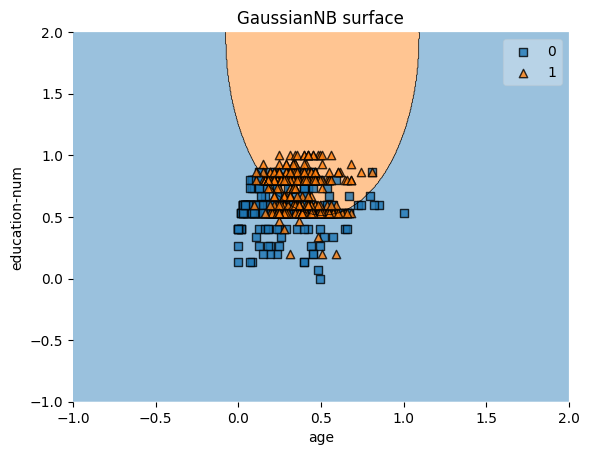

In [435]:
sk_nb_clf = GaussianNB()
sk_nb_clf.fit(X_train.values, y_train.values)
sk_nb_clf_pred_res = sk_nb_clf.predict(X_test.values)
sk_nb_clf_accuracy = accuracy_score(y_test.values, sk_nb_clf_pred_res)

print(f'sk Naive Bayes classifier accucacy: {sk_nb_clf_accuracy}')
print(sk_nb_clf_pred_res)

feature_indexes = [0,4]
title1 = 'GaussianNB surface'
decision_boundary_plot(X, y, X_train.values, y_train.values, sk_nb_clf, feature_indexes, title1)

## Вывод
Точность классификатора составила около 0.69. Это означает, что означает модель правильно классифицировала примерно 69% из тестовой выборки.

Массив предсказанных результатов показывает, как модель классифицировала отдельные экземпляры ежедневной выборки. В первых нескольких предсказаниях есть как положительные (1), так и отрицательные (0) классы, что указывает на наличие как успешных, так и неудачных классификаций. Анализ отдельных ошибок может помочь в дальнейшем улучшении модели. 

Визуализация (decision_boundary_plot) позволяет увидеть, как классификатор разделяет классы на плоскости, созданные на основе двух указанных признаков (в данном случае age и education-num). Визуализация показала, что к классу людей, имеющих годовой доход превышающий 50 000 долларов, относятся люди среднего возраста с образованием средним и выше среднего. Эта информация будет полезна для оценки работы классификатора — насколько хорошо он отделяет разные классы. В нашем случае видно, что модель ошибочно определяет классы для некоторых для некоторых наблюдений. 

## Ответы на контрольные вопросы



### Сформулируйте постановку задачи классификации.

Задача классификации, задача машинного обучения по разделению выборки объектов на дискретное (конечное) множество классов. Каждый объект требуется отнести к одному из заранее определённых классов.

В формальной постановке задачи классификации имеется множество объектов $X$ и множество ответов $Y$. Предполагается, что существует функциональная зависимость $f: X\to Y$ между объектами и ответами, но она неизвестна. Известна лишь совокупность $S$ пар вида (объект, ответ), называемая обучающей выборкой:
$$ S={(x_{i},y_{x_{i}} =f(x_{i}))\in  X\times Y ∣ i=1,...,l} $$

При этом множество ответов $Y$ является конечным, а каждый ответ $y \in Y$ соответствует некоторому классу объектов.

Задача классификации заключается в вычислении для каждого объекта соответствующего ему класса. Качество алгоритма решения задачи классификации измеряют с помощью метрик на тестовой выборке, которая не использовалась для обучения.


### Что такое априорная вероятность.

Априорная или безусловная вероятность, связанная с некоторым случайным событием $A$, представляет собой степень уверенности в том, что данное событие произошло, в отсутствие любой другой информации, связанной с этим событием. Ее знание необходимо для вычисления апостериорных вероятностей в простом классификаторе Байеса.

### Что такое условная вероятность события.
Если $A$ и $B$ – события и $P(B) > 0$, то условная вероятность P(A∣B) события A относительно (или при условии ) B определяется равенством
$$P(A∣B)= \frac{P(B)}{P(A\cap B)}$$.
Условная вероятность $P(A∣B)$ может рассматриваться как вероятность осуществления события $A$ при условии, что событие $B$ осуществилось. Для независимых событий $A$ и $B$ условная вероятность $P(A∣B)$ совпадает с безусловной вероятностью $P(A)$.

### Что такое апостериорная вероятность события.

Апостериорная вероятность - это разновидность условной вероятности, которая получается в результате обновления априорной вероятности с учетом вероятности наступления события с помощью правила Байеса.

### Дайте определение наивному байесовскому классификатору.

Наивный байесовский классификатор (Naive Bayes classifier) — вероятностный классификаторна основе формулы Байеса со строгим (наивным) предположением о независимости признаков
между собой при заданном классе, что сильно упрощает задачу классификации из-за оценкиодномерных вероятностных плотностей вместо одной многомерной. 

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)},$$

где:

$P(A|B)$ — апостериорная (послеопытная) вероятность события A при условиивыполнения события B;

$P(B|A)$ — условная вероятность события B при условии выполнения события A;

$P(A), P(B)$ — априорные вероятности событий A и B соответственно.


### Определите байесовский классификатор в контексте машинного обучения.

В контексте машинного обучения формула Байеса приобретает следующий вид:

$$P(y_{k}|X) = \frac{P(X|y_{k})P(y_{k})}{P(X)},$$

где:

$P(y_{k}|X)$ — апостериорная (послеопытная) вероятность события $y_{k}$ при условиивыполнения события $X$;

$P(X|y_{k})$ — условная вероятность события $X$ при условии выполнения события $y_{k}$;

$P(y_{k}), P(X)$ — априорные вероятности событий $y_{k}$ и $X$ соответственно.



### Охарактеризуйте идею метода максимального правдоподобия.

Метод максимального правдоподобия (ММП) — это один из основных статистических методов, используемых для оценки параметров моделей. Этот метод широко применяется в различных областях, таких как биостатистика, эконометрика, машинное обучение и многие другие. Основная идея метода заключается в том, чтобы найти такие значения параметров, которые максимизируют вероятность наблюдаемых данных. В отличие от других методов, ММП позволяет получить оценки, которые обладают хорошими асимптотическими свойствами, такими как состоятельность и асимптотическая нормальность.

Цель метода максимального правдоподобия — найти такие значения параметров, которые максимизируют функцию правдоподобия. 

### Какие разновидности наивного Байеса существуют в библиотеке scikit-learn.

В библиотеке scikit-learn есть несколько реализаций наивного байесовского классификатора,отличающиеся предположениями о распределении признаков при заданном классе. К таковымотносятся следующие:

- **Гауссовский наивный байесовский классификатор (GaussianNB)** — вариант дляработы с непрерывными признаками, которые имеют нормальное (гауссовское)распределение.

- **Мультиномиальный наивный байесовский классификатор (MultinomialNB)** — вариантдля работы с дискретными признаками, которые имеют мультиномиальное распределение.Такие признаки часто встречаются в задачах классификации текстов, где они представляютсобой количество вхождений в тексте.

- **Комплементарный наивный байесовский классификатор (ComplementNB)** — улучшенный вариант MultinomialNB, подходящий для несбалансированных наборов данных.Вместо оценки вероятности признака при заданном классе, алгоритм оцениваетнормированный вес признака для класса как вероятность признака при дополнении класса, то есть при всех остальных классах. Таким образом, алгоритм учитывает не толькочастоту признаков в классе, но и их отсутствие в других классах, что делает его менеечувствительным к смещению выборки.

- **Бернуллиевский наивный байесовский классификатор (BernoulliNB)** — ещё одинвариант для работы с дискретными признаками, но которые имеют бернуллиевскоераспределение. В данном случае признаки представляют собой бинарные индикаторыналичия или отсутствия определённых свойств в объекте. Например, в задачеклассификации текстов это может быть наличие или отсутствие определённых слов втексте.

- **Категориальный наивный байесовский классификатор (CategoricalNB)** — вариант длякатегориально распределенных данных, основанный на предположении, что каждыйописываемый индексом признак имеет своё собственное категориальное распределение.


### В чем суть "обучения" для наивного байесовского классификатора.

Суть "обучения" наивного байесовского классификатора сводится к оценке параметров модели, которые позволяют вычислять вероятности классов на основе предоставленных данных. Этот алгоритм является популярным из-за своей простоты и эффективности, особенно когда предположение о независимости признаков достаточно близко к реальному состоянию дел.